关于股票是否处于高位或者地位，通常常用当前股价处于历史序列的百分位水平来进行判断
关于是否放量，通常观察当前的成交量或者换手率相对于过去一段时间是否异常放大

低位放量事件：
当日收盘价处于过去120个交易日的10%分位数及以下
当日换手率高于过去120个交易日换手率的均值+2倍标准差

高位放量事件：
当日收盘价处于过去120个交易日的90%分位数及以上
当日换手率高于过去120个交易日换手率的均值+2倍标准差

将换手率改成股价波动率，每日的波动率的使用当日的分钟数据计算，1分钟收益率序列的标准差

In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial
import matplotlib as mpl

In [2]:
close = ff.read('close') * ff.read('post')

In [3]:
data_all = pd.read_pickle('/mydata2/wangs/data/fmins/close.pk')

In [4]:
close_judge_low = (close <= close.rolling(window = 120,axis = 1,closed = 'left').quantile(0.1,axis = 1)).loc[data_all.columns,'20200103':'20240227']
close_judge_high = (close >= close.rolling(window = 120,axis = 1,closed = 'left').quantile(0.9,axis = 1)).loc[data_all.columns,'20200103':'20240227']

In [5]:
data_float_all = (data_all-data_all.shift(1))/data_all.shift(1)  #计算分钟收益率

In [6]:
data_float_std = data_float_all.rolling(window = 240,closed = 'left').std() 

In [7]:
day_float_std = [data_float_std.iloc[240*x-1].values for x in range(1,int(len(data_float_std)/240)+1)]

In [8]:
float_all = pd.DataFrame(day_float_std).drop(0,axis = 0)
float_all.columns = data_float_std.columns
float_all.index = close.loc[:,'20200103':'20240227'].T.index

In [9]:
float_factor = float_all.T

In [327]:
float_judge = (float_all > float_all.rolling(window = 120,axis = 0,closed = 'left').mean() + 2*float_all.rolling(window = 120,axis = 0,closed = 'left').std()).T

In [10]:
(float_judge * close_judge_high).loc[:,'20200103':'20230717'].sum()

20200103      0
20200106      0
20200107      0
20200108      0
20200109      0
           ... 
20230711     88
20230712    104
20230713     98
20230714     82
20230717     91
Length: 856, dtype: int64

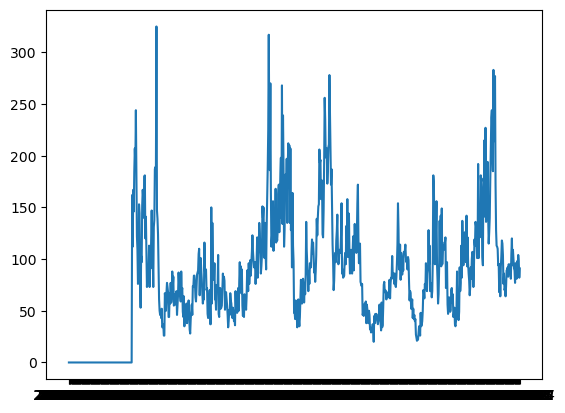

In [11]:
plt.plot((float_judge * close_judge_high).loc[:,'20200103':'20230717'].sum())

选股因子

每月月底，将每支股票过去20个交易日的换手率，按照每日的收盘价，从低到高进行排序，等分为5组

In [31]:
def factor_five(list):
    index = []
    for i,j in enumerate(sorted(enumerate(list), key=lambda x: x[1])):
        index.append((i,j[0]))
    index = [x[0]//4 for x in sorted(index,key=lambda x: x[1])]
    return index
def factor_all(n):
    close = (ff.read('close') * ff.read('post')).loc[:,'20191205':'20240319'] 
    turnover_rate = (ff.read('turnover_rate')* ff.read('post')).loc[:,'20191205':'20240319']
    factor_choose = (close.iloc[:,n-20:n].T).apply(factor_five).T
    factor = [(((factor_choose == i) * (turnover_rate.iloc[:,n-20:n])).sum(axis=1) / turnover_rate.iloc[:,n-20:n].sum(axis = 1)).values for i in range(5)]
    return factor

使用a[np.argpartition(a, 4)] 或者argsort

In [78]:
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(factor_all, range(20,1039)), total=len(range(20,1039))))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [02:43<00:00,  6.24it/s]


In [79]:
factor_1= pd.DataFrame([res_lst[i][0] for i in range(len(res_lst))]).T
factor_2= pd.DataFrame([res_lst[i][1] for i in range(len(res_lst))]).T
factor_3= pd.DataFrame([res_lst[i][2] for i in range(len(res_lst))]).T
factor_4= pd.DataFrame([res_lst[i][3] for i in range(len(res_lst))]).T
factor_5= pd.DataFrame([res_lst[i][4] for i in range(len(res_lst))]).T

In [80]:
factor_1.index = ff.read('close').index
factor_1.columns = ff.read('close').columns[2432:3451]
factor_2.index = ff.read('close').index
factor_2.columns = ff.read('close').columns[2432:3451]
factor_3.index = ff.read('close').index
factor_3.columns = ff.read('close').columns[2432:3451]
factor_4.index = ff.read('close').index
factor_4.columns = ff.read('close').columns[2432:3451]
factor_5.index = ff.read('close').index
factor_5.columns = ff.read('close').columns[2432:3451]

In [35]:
import extend
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_style("whitegrid")
sns.set_palette("Pastel1")
mpl.rc("font",family='Droid Sans Fallback',weight="bold")
mv = ff.read('total_mv').loc[ff.read('close').index,ff.read('close').columns[2432:3451]]
factor_neu = extend.spread_reg(factor_5, mv, ind=True)

long normal
持仓模式： 普通模式
持仓周期： 20
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


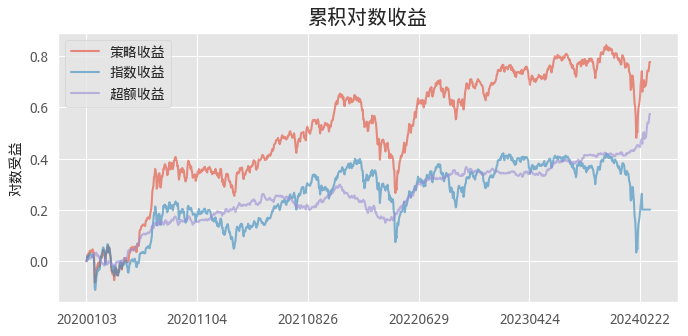

,指数收益,超额收益,策略收益
年化收益率,0.049,0.141,0.190
年化波动率,0.216,0.080,0.228
夏普率,0.229,1.758,0.836
最大回撤,-0.387,-0.149,-0.388
收益回撤比,0.127,0.942,0.491
胜率,0.522,0.527,0.543
盈亏比,0.952,1.224,0.974


(        指数收益   超额收益   策略收益
 年化收益率  0.049  0.141  0.190
 年化波动率  0.216  0.080  0.228
 夏普率    0.229  1.758  0.836
 最大回撤  -0.387 -0.149 -0.388
 收益回撤比  0.127  0.942  0.491
 胜率     0.522  0.527  0.543
 盈亏比    0.952  1.224  0.974,
                 策略     index          策略收益      指数收益      超额收益
 20200103  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200106  1.008118  1.007212  8.084773e-03  0.007186  0.000905
 20200107  1.025836  1.020085  2.550744e-02  0.019886  0.005688
 20200108  1.016985  1.006640  1.684238e-02  0.006618  0.010230
 20200109  1.030892  1.021502  3.042404e-02  0.021274  0.009140
 ...            ...       ...           ...       ...       ...
 20240313  2.101564  1.222478  7.426820e-01  0.200880  0.539927
 20240314  2.096918  1.222478  7.404688e-01  0.200880  0.537714
 20240315  2.126771  1.222478  7.546047e-01  0.200880  0.551850
 20240318  2.173956  1.222478  7.765486e-01  0.200880  0.573794
 20240319  2.173486  1.222478  7.763321e-01  0.200880  0.573577
 
 [101

In [36]:
ff.run(factor_neu*ff.filter0, positions = 100, period = 20, fees = 0) 

In [37]:
def factor_all_float(n):
    close = (ff.read('close')* ff.read('post')).loc[:,'20200103':'20240227']
    float_rate = float_factor.loc[:,'20200103':'20240227']
    factor_choose = (close.iloc[:,n-20:n].T).apply(factor_five).T
    factor = [(((factor_choose == i) * (float_rate.iloc[:,n-20:n])).sum(axis=1)*5 / float_rate.iloc[:,n-20:n].mean(axis = 1)).values for i in range(5)] 
    return factor

In [38]:
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(factor_all_float, range(20,1004)), total=len(range(20,1004))))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 984/984 [01:24<00:00, 11.58it/s]


In [39]:
factor_1_float= pd.DataFrame([res_lst[i][0] for i in range(len(res_lst))]).T
factor_2_float= pd.DataFrame([res_lst[i][1] for i in range(len(res_lst))]).T
factor_3_float= pd.DataFrame([res_lst[i][2] for i in range(len(res_lst))]).T
factor_4_float= pd.DataFrame([res_lst[i][3] for i in range(len(res_lst))]).T
factor_5_float= pd.DataFrame([res_lst[i][4] for i in range(len(res_lst))]).T
factor_1_float.index = ff.read('close').index
factor_1_float.columns = ff.read('close').columns[2452:3436]
factor_2_float.index = ff.read('close').index
factor_2_float.columns = ff.read('close').columns[2452:3436]
factor_3_float.index = ff.read('close').index
factor_3_float.columns = ff.read('close').columns[2452:3436]
factor_4_float.index = ff.read('close').index
factor_4_float.columns = ff.read('close').columns[2452:3436]
factor_5_float.index = ff.read('close').index
factor_5_float.columns = ff.read('close').columns[2452:3436]

long normal
持仓模式： 普通模式
持仓周期： 20
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


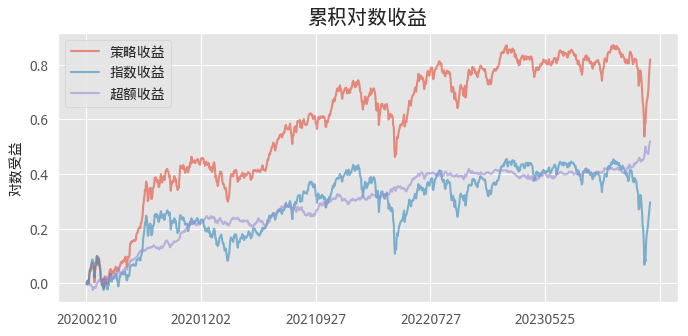

,指数收益,超额收益,策略收益
年化收益率,0.075,0.132,0.208
年化波动率,0.210,0.069,0.216
夏普率,0.359,1.913,0.963
最大回撤,-0.387,-0.043,-0.335
收益回撤比,0.195,3.088,0.622
胜率,0.530,0.532,0.538
盈亏比,0.940,1.217,1.014


(        指数收益   超额收益   策略收益
 年化收益率  0.075  0.132  0.208
 年化波动率  0.210  0.069  0.216
 夏普率    0.359  1.913  0.963
 最大回撤  -0.387 -0.043 -0.335
 收益回撤比  0.195  3.088  0.622
 胜率     0.530  0.532  0.538
 盈亏比    0.940  1.217  1.014,
                 策略     index          策略收益      指数收益      超额收益
 20200210  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200211  0.997633  0.994574 -2.370257e-03 -0.005441  0.003054
 20200212  1.009604  1.010518  9.557833e-03  0.010463 -0.000986
 20200213  0.998262  1.000783 -1.739133e-03  0.000782 -0.002586
 20200214  0.998351  1.002446 -1.650213e-03  0.002443 -0.004161
 ...            ...       ...           ...       ...       ...
 20240221  1.986684  1.229661  6.864672e-01  0.206739  0.474965
 20240222  2.028248  1.257539  7.071726e-01  0.229156  0.473214
 20240223  2.130900  1.291186  7.565443e-01  0.255561  0.496788
 20240226  2.193646  1.309862  7.855649e-01  0.269922  0.511658
 20240227  2.268274  1.345092  8.190193e-01  0.296462  0.518758
 
 [984

In [41]:
mv = ff.read('total_mv').loc[ff.read('close').index,ff.read('close').columns[2452:3436]]
factor_neu = extend.spread_reg(factor_1_float, mv, ind=True)
ff.run(factor_1_float*ff.filter0, positions = 100, period = 20, fees = 0) 

基于分钟数据的因子选股

In [10]:
data_min_float = data_float_all.rolling(window = 5,closed = 'left').std() 

In [11]:
data_min_float.sum()

000001.SZ    274.205185
000002.SZ    275.390828
000004.SZ    400.516286
000005.SZ    648.318622
000006.SZ    451.147187
                ...    
601558.SH    172.476309
603157.SH    343.414403
603996.SH    307.280113
688086.SH    372.577087
688555.SH    288.493224
Length: 5234, dtype: float64

In [110]:
day = data_min_float.iloc[:,0][data_min_float.iloc[:,0].index.str.endswith('15:00:00')]
grouped = day.groupby(pd.to_datetime(day.index).strftime('%Y%m'))
final_day = []
for i, j in grouped:
    final_day.append(j.index[-1])

In [77]:
def monthly_float_mean(n): 
    list = data_min_float.loc[:final_day[n],].iloc[-240*21:-240,:]
    close_list = data_all.loc[:final_day[n],].iloc[-240*21:-240,:]
    ratio = ((close_list > close_list.quantile(0.8)) *list).replace({0:np.nan}).mean()/np.nanmean(list)  #这里面由于是每一分钟的收盘价，所以这个数据可能相同的出现的比较多，quantile和partition可能存在误差
    return ratio.values

In [14]:
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(monthly_float_mean, range(50)), total=len(range(50))))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.02it/s]


In [111]:
monthly_float = data_min_float.loc[final_day,]
monthly_float_factor = pd.DataFrame(res_lst)
monthly_float_factor.index = monthly_float.index
monthly_float_factor.columns = monthly_float.columns

In [112]:
monthly_float_factor

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,600890.SH,600891.SH,600896.SH,600978.SH,601258.SH,601558.SH,603157.SH,603996.SH,688086.SH,688555.SH
2020-01-23 15:00:00,0.718493,0.695777,1.106950,1.531568,0.987499,0.696279,1.381190,2.264156,1.751895,0.611831,...,1.229420,2.941231,1.456180,1.607952,3.092281,3.856192,2.042485,1.408483,NaN,NaN
2020-02-28 15:00:00,0.536231,0.649861,2.970545,1.326323,0.941866,1.069569,1.288233,1.763356,1.049374,0.597491,...,1.058333,2.529058,1.139662,1.489742,2.653766,3.336617,1.421720,1.162206,2.710335,NaN
2020-03-31 15:00:00,0.519742,0.706006,2.651343,1.108989,0.997572,0.982649,1.451453,0.989668,0.931864,0.713509,...,14.042490,NaN,3.831773,1.271008,2.350174,3.130914,0.942925,1.125890,1.798348,NaN
2020-04-30 15:00:00,0.717788,0.549456,1.534379,1.403429,1.328570,0.719027,1.395293,1.268488,1.279855,1.037676,...,1.112931,NaN,1.557002,1.587840,3.280132,12.631847,1.470409,1.246882,1.095165,NaN
2020-05-29 15:00:00,0.635023,0.495701,1.537459,1.523595,1.148064,0.949815,1.479057,1.275712,1.362088,0.758075,...,1.378199,NaN,1.517595,3.815071,3.427114,NaN,2.332656,2.077995,1.401968,NaN
2020-06-30 15:00:00,0.653462,0.769696,0.920120,1.803560,1.985688,0.829122,1.522228,1.074770,1.219554,3.180854,...,0.977218,NaN,1.960773,3.681958,3.469106,17.872100,2.365301,1.970883,1.506432,2.790527
2020-07-31 15:00:00,0.957499,0.812263,1.027011,1.599156,1.799274,0.825053,1.266572,1.573128,1.428329,2.970401,...,1.254352,NaN,1.183461,2.963492,2.921028,NaN,1.462287,1.468283,1.319038,0.924507
2020-08-31 15:00:00,0.768031,0.604574,0.533421,1.482185,1.967221,0.782098,1.375335,0.910840,1.295677,2.672065,...,1.186547,NaN,1.242448,3.159043,3.241400,NaN,1.415886,1.873961,0.916762,0.737798
2020-09-30 15:00:00,0.665251,0.597102,0.972181,1.356550,1.229764,0.892892,1.252735,0.786527,1.827697,1.296130,...,0.682190,NaN,1.125589,2.882655,3.398414,NaN,1.607133,2.295218,0.738293,0.524188
2020-10-30 15:00:00,1.139595,0.660549,0.956258,1.718232,1.216174,0.973238,1.486290,0.841818,2.424003,1.159820,...,1.325978,NaN,0.989129,4.003195,3.804958,NaN,1.705735,1.564915,0.688659,0.701331


In [113]:
final_day = [pd.to_datetime(i).strftime('%Y%m%d') for i in final_day]

In [114]:
monthly_float_factor.index = final_day
monthly_float_factor = monthly_float_factor.T
monthly_float_factor

,20200123,20200228,20200331,20200430,20200529,20200630,20200731,20200831,20200930,20201030,...,20230531,20230630,20230731,20230831,20230928,20231031,20231130,20231229,20240131,20240227
000001.SZ,0.718493,0.536231,0.519742,0.717788,0.635023,0.653462,0.957499,0.768031,0.665251,1.139595,...,0.934230,0.629568,0.669469,0.669513,0.652710,0.527313,0.602490,0.603842,0.728643,0.606730
000002.SZ,0.695777,0.649861,0.706006,0.549456,0.495701,0.769696,0.812263,0.604574,0.597102,0.660549,...,0.826115,0.798804,0.873076,0.822766,0.797719,0.480718,0.963906,0.686646,0.734510,0.641334
000004.SZ,1.106950,2.970545,2.651343,1.534379,1.537459,0.920120,1.027011,0.533421,0.972181,0.956258,...,4.818396,2.006029,4.167754,1.955443,1.433347,1.870394,1.680017,0.857954,1.341723,1.018925
000005.SZ,1.531568,1.326323,1.108989,1.403429,1.523595,1.803560,1.599156,1.482185,1.356550,1.718232,...,2.685771,3.665707,3.604890,2.900498,3.256388,3.202477,3.451258,3.027252,3.716319,2.735298
000006.SZ,0.987499,0.941866,0.997572,1.328570,1.148064,1.985688,1.799274,1.967221,1.229764,1.216174,...,1.350433,1.229934,1.778260,2.762914,1.755997,1.193010,2.884100,1.306521,1.674178,1.259112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601558.SH,3.856192,3.336617,3.130914,12.631847,NaN,17.872100,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603157.SH,2.042485,1.421720,0.942925,1.470409,2.332656,2.365301,1.462287,1.415886,1.607133,1.705735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603996.SH,1.408483,1.162206,1.125890,1.246882,2.077995,1.970883,1.468283,1.873961,2.295218,1.564915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688086.SH,NaN,2.710335,1.798348,1.095165,1.401968,1.506432,1.319038,0.916762,0.738293,0.688659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
fac_new = monthly_float_factor.reindex(ff.idt,axis = 1)
fac_new = fac_new.loc[:,monthly_float_factor.columns[0]:]
for i in fac_new.columns:
    if fac_new[i].count()==0:
        fac_new[i] = fac_new[ff.delay(i,-1)]

In [133]:
fac_new

,20200123,20200203,20200204,20200205,20200206,20200207,20200210,20200211,20200212,20200213,...,20240308,20240311,20240312,20240313,20240314,20240315,20240318,20240319,20240320,20240321
000001.SZ,0.718493,0.718493,0.718493,0.718493,0.718493,0.718493,0.718493,0.718493,0.718493,0.718493,...,0.606730,0.606730,0.606730,0.606730,0.606730,0.606730,0.606730,0.606730,0.606730,0.606730
000002.SZ,0.695777,0.695777,0.695777,0.695777,0.695777,0.695777,0.695777,0.695777,0.695777,0.695777,...,0.641334,0.641334,0.641334,0.641334,0.641334,0.641334,0.641334,0.641334,0.641334,0.641334
000004.SZ,1.106950,1.106950,1.106950,1.106950,1.106950,1.106950,1.106950,1.106950,1.106950,1.106950,...,1.018925,1.018925,1.018925,1.018925,1.018925,1.018925,1.018925,1.018925,1.018925,1.018925
000005.SZ,1.531568,1.531568,1.531568,1.531568,1.531568,1.531568,1.531568,1.531568,1.531568,1.531568,...,2.735298,2.735298,2.735298,2.735298,2.735298,2.735298,2.735298,2.735298,2.735298,2.735298
000006.SZ,0.987499,0.987499,0.987499,0.987499,0.987499,0.987499,0.987499,0.987499,0.987499,0.987499,...,1.259112,1.259112,1.259112,1.259112,1.259112,1.259112,1.259112,1.259112,1.259112,1.259112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601558.SH,3.856192,3.856192,3.856192,3.856192,3.856192,3.856192,3.856192,3.856192,3.856192,3.856192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603157.SH,2.042485,2.042485,2.042485,2.042485,2.042485,2.042485,2.042485,2.042485,2.042485,2.042485,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603996.SH,1.408483,1.408483,1.408483,1.408483,1.408483,1.408483,1.408483,1.408483,1.408483,1.408483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688086.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
